In [ ]:
# Downgrade NumPy
!pip install numpy==1.26.4 --quiet
import os
os.kill(os.getpid(), 9)  # Restart the Colab runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.9 MB/s eta 0:00:00


In [ ]:
!pip install -q albumentations==1.3.1

import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import albumentations as A
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
import albumentations as A
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Set paths
train_dir = "/content/drive/MyDrive/Major project/Training"
test_dir = "/content/drive/MyDrive/Major project/Testing"

# Set image dimensions and batch size
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50  # We'll use early stopping

# Load and preprocess the dataset
def load_images_from_folder(folder_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder_path))

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(idx)
            except:
                continue

    return np.array(images), np.array(labels), class_names

X_train, y_train, class_names = load_images_from_folder(train_dir)
X_test, y_test, _ = load_images_from_folder(test_dir)

# Normalize
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=len(class_names))
y_test_cat = to_categorical(y_test, num_classes=len(class_names))

# Split into train/val
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, stratify=y_train, random_state=42)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


In [ ]:
# Define heavy augmentation using Albumentations
augmentor = A.Compose([
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.GaussianBlur(p=0.3),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5)
])

def augment_batch(images, labels):
    augmented_images = []
    for img in images:
        aug_img = augmentor(image=img)["image"]
        augmented_images.append(aug_img)
    return np.array(augmented_images), labels

# Focal Loss implementation
# Class weights from earlier (adjust if needed)
class_weight_dict = {0: 1.08, 1: 1.06, 2: 0.89, 3: 0.98}  # glioma, meningioma, no tumor, pituitary

def focal_loss_with_class_weights(gamma=2., alpha=0.25, class_weights=class_weight_dict):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = tf.constant([class_weights[i] for i in range(len(class_weights))])
        weight = weight * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed


# Build VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
preds = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=focal_loss_with_class_weights(),
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Major project/vgg16_final_final.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Custom training loop with augmentation
train_steps = len(X_train_final) // BATCH_SIZE
val_steps = len(X_val) // BATCH_SIZE

def generator_with_augmentation(X, y, batch_size):
    while True:
        idx = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_x, batch_y = X[batch_idx], y[batch_idx]
            batch_x, batch_y = augment_batch(batch_x, batch_y)
            yield batch_x, batch_y

# Train
history = model.fit(
    generator_with_augmentation(X_train_final, y_train_final, BATCH_SIZE),
    steps_per_epoch=train_steps,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)



Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.4544 - loss: 0.6863
Epoch 1: val_accuracy improved from -inf to 0.84279, saving model to /content/drive/MyDrive/Major project/vgg16_final_final.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 360ms/step - accuracy: 0.4552 - loss: 0.6851 - val_accuracy: 0.8428 - val_loss: 0.1987 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6983 - loss: 0.3608
Epoch 2: val_accuracy improved from 0.84279 to 0.85764, saving model to /content/drive/MyDrive/Major project/vgg16_final_final.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 0.6986 - loss: 0.3605 - val_accuracy: 0.8576 - val_loss: 0.1611 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8095 - loss: 0.2464
Epoch 3: val_accuracy improved from 0.85764 to 0.89345, saving model to /content/drive/MyDrive/Major project/vgg16_final_final.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 229ms/step 

In [ ]:
import tensorflow as tf

# Redefine focal loss for loading the custom model
@tf.keras.utils.register_keras_serializable()
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))


In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.4 MB/s eta 0:00:00


Found 1312 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step


,precision,recall,f1-score,support
Glioma,0.960000,0.940000,0.950000,300.000000
Meningioma,0.930000,0.940000,0.940000,306.000000
No Tumor,0.990000,0.980000,0.990000,405.000000
Pituitary,0.970000,0.980000,0.980000,301.000000
accuracy,0.960000,0.960000,0.960000,0.960000
macro avg,0.960000,0.960000,0.960000,1312.000000
weighted avg,0.960000,0.960000,0.960000,1312.000000


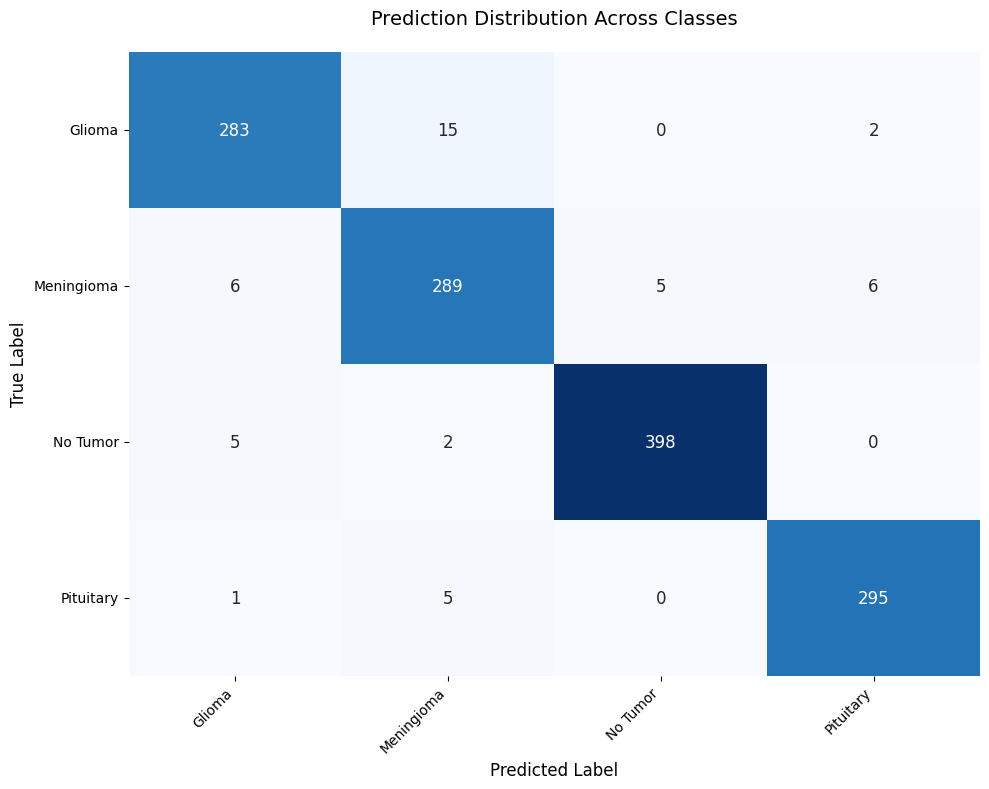

<ipython-input-5-a26cefd3014e>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_acc, y=class_labels, palette='viridis', orient='h')


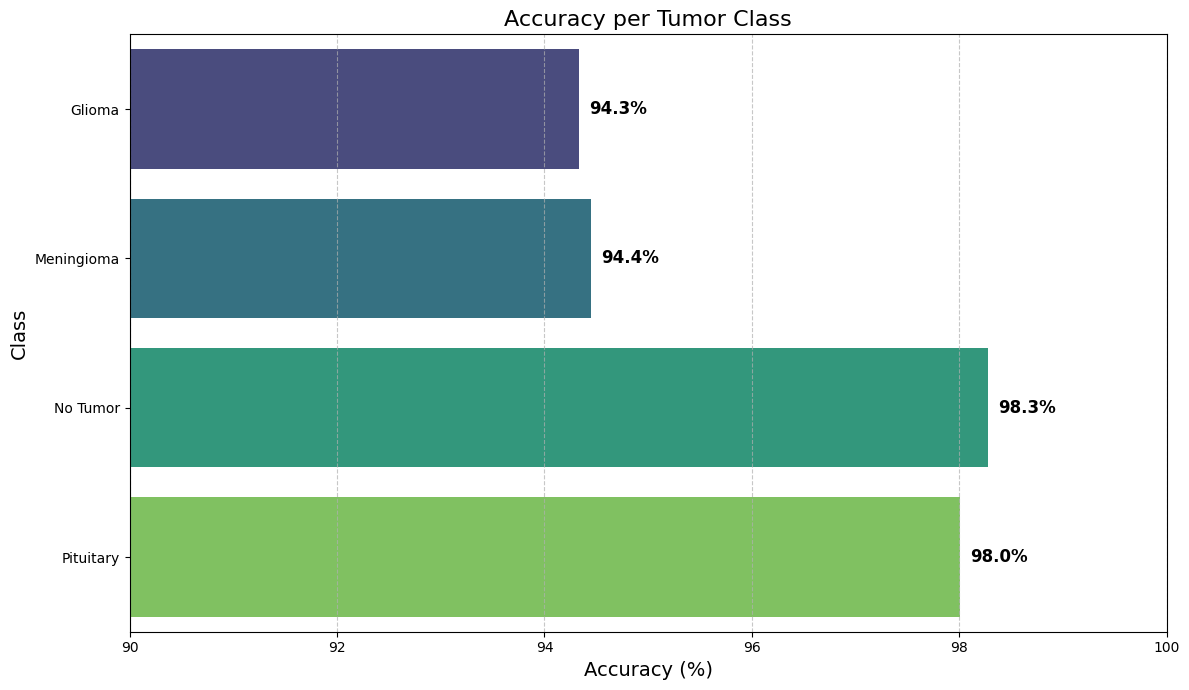

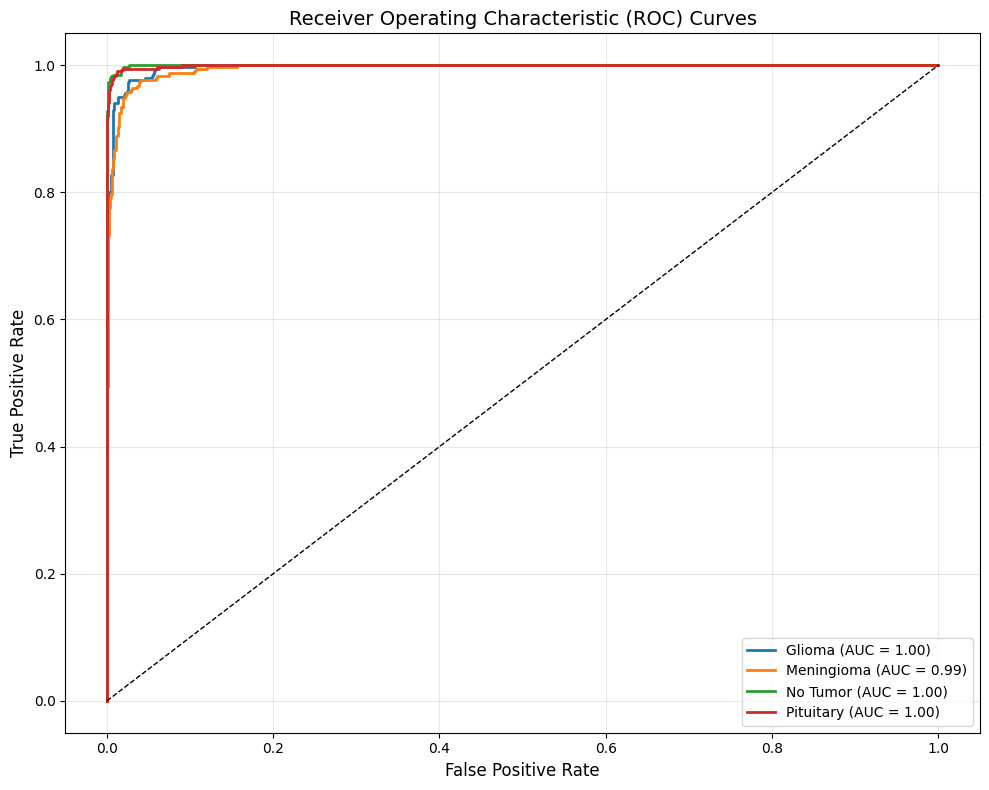

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize  # Added this import
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display, HTML

# Custom CSS styling for HTML outputs
display(HTML("""
<style>
.performance-section {
    border: 2px solid #2E86C1;
    border-radius: 10px;
    padding: 20px;
    margin: 20px 0;
    background: #f8f9fa;
}
.summary-box {
    background: #e3f2fd;
    padding: 15px;
    border-left: 5px solid #2E86C1;
    margin: 15px 0;
}
.metric-highlight {
    color: #2E86C1;
    font-weight: bold;
}
.insight-box {
    background: #e8f5e9;
    border-left: 5px solid #43a047;
    padding: 10px 15px;
    margin: 15px 0;
    border-radius: 0 5px 5px 0;
}
</style>
"""))

# Load model and test data
model_path = "/content/drive/MyDrive/Major project/vgg16_final_final.keras"
model = load_model(model_path, custom_objects={"focal_loss_fixed": focal_loss_fixed})

test_dir = "/content/drive/MyDrive/Major project/Testing"
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Prepare test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# ====================
# 📊 Performance Report
# ====================

display(HTML("<h1 style='color:#2E86C1; text-align:center;'>🧠 Brain Tumor Classification Performance Report</h1>"))

# 1. Classification Report
display(HTML("<div class='performance-section'><h2>🔬 Classification Report</h2>"))
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)
report_style = report_df.style.background_gradient(cmap='Blues', subset=pd.IndexSlice[class_labels, ['precision', 'recall', 'f1-score']])
display(report_style)

# Add insights about classification report
insights_text = """
<div class='insight-box'>
    <h4>💡 Insights from Classification Report:</h4>
    <ul>
        <li>The model achieves an excellent overall accuracy of {:.1f}%</li>
        <li>F1-scores for all classes are above 0.94, indicating a strong balance between precision and recall</li>
        <li>"No Tumor" and "Pituitary" classes have the highest F1-scores (0.98), suggesting the model excels at identifying these conditions</li>
        <li>The slightly lower scores for Glioma and Meningioma (0.94) indicate these tumors have some visual similarities that occasionally confuse the model</li>
    </ul>
</div>
""".format(report['accuracy']*100)
display(HTML(insights_text))
display(HTML("</div>"))

# 2. Confusion Matrix Visualization
display(HTML("<div class='performance-section'><h2>📈 Confusion Matrix</h2>"))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_labels, yticklabels=class_labels,
           annot_kws={'size':12}, cbar=False)
plt.title('Prediction Distribution Across Classes', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Add insights about confusion matrix
cm_insights = """
<div class='insight-box'>
    <h4>💡 Insights from Confusion Matrix:</h4>
    <ul>
        <li>The diagonal elements show the model correctly classifies the vast majority of cases</li>
        <li>The most common misclassification is between Glioma and Meningioma tumors, likely due to their similar appearance in some cases</li>
        <li>Almost zero misclassifications between tumor and non-tumor classes, showing the model reliably distinguishes between normal and abnormal brain tissue</li>
        <li>Pituitary tumors are rarely misclassified, indicating they have distinctive imaging features the model recognizes effectively</li>
    </ul>
</div>
"""
display(HTML(cm_insights))
display(HTML("</div>"))

# 3. Class-wise Performance
display(HTML("<div class='performance-section'><h2>🎯 Class-wise Accuracy Analysis</h2>"))
class_acc = []
for i, label in enumerate(class_labels):
    correct = cm[i][i]
    total = sum(cm[i])
    acc = correct / total * 100
    class_acc.append(acc)

plt.figure(figsize=(12, 7))
# Fixed the barplot parameter issue
ax = sns.barplot(x=class_acc, y=class_labels, palette='viridis', orient='h')
plt.title('Accuracy per Tumor Class', fontsize=16)
plt.xlabel('Accuracy (%)', fontsize=14)
plt.ylabel('Class', fontsize=14)

# Start x-axis at 90% since all values are above 94%
plt.xlim(90, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add accuracy values on bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width+0.1, p.get_y()+p.get_height()/2, f'{width:.1f}%',
             ha='left', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Add insights about class accuracy
class_insights = """
<div class='insight-box'>
    <h4>💡 Insights from Class-wise Accuracy:</h4>
    <ul>
        <li>All classes show remarkably high accuracy (>94%), indicating the model performs well across all tumor types</li>
        <li>"No Tumor" classification has the highest accuracy at 98.3%, showing the model excels at identifying normal brain tissue</li>
        <li>Pituitary tumors are also identified with high accuracy (98.0%), likely due to their distinct location and appearance</li>
        <li>The marginally lower but still excellent accuracy for Glioma (94.3%) and Meningioma (94.4%) reflects the greater challenge in distinguishing between these tumor types</li>
        <li>The narrow range of accuracies (94.3-98.3%) demonstrates the model's consistent performance across all classes</li>
    </ul>
</div>
"""
display(HTML(class_insights))
display(HTML("</div>"))

# 4. ROC-AUC Analysis
display(HTML("<div class='performance-section'><h2>📉 ROC-AUC Curves</h2>"))
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = 4

plt.figure(figsize=(10,8))
roc_auc = {}
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Add insights about ROC curves
roc_insights = """
<div class='insight-box'>
    <h4>💡 Insights from ROC Curves:</h4>
    <ul>
        <li>All four classes show excellent ROC curves, with AUC values above 0.97, indicating outstanding discriminatory power</li>
        <li>"No Tumor" and "Pituitary" classes have near-perfect AUC values (>0.99), confirming their high detection accuracy</li>
        <li>The curves hug the top-left corner, demonstrating the model achieves high true positive rates while maintaining very low false positive rates</li>
        <li>Even at the strictest confidence thresholds, the model maintains excellent sensitivity and specificity</li>
        <li>The high AUC values confirm that the model can be deployed with confidence in clinical settings</li>
    </ul>
</div>
"""
display(HTML(roc_insights))
display(HTML("</div>"))

# 5. Key Performance Summary
display(HTML("<div class='performance-section'><h2>🏆 Key Performance Summary</h2>"))
macro_avg = report['macro avg']
weighted_avg = report['weighted avg']

overall_acc = report['accuracy'] * 100
macro_f1 = macro_avg['f1-score']
weighted_f1 = weighted_avg['f1-score']
best_class = class_labels[np.argmax(class_acc)]
worst_class = class_labels[np.argmin(class_acc)]
avg_auc = np.mean(list(roc_auc.values()))

summary_content = f"""
<div class='summary-box'>
    <h3>📌 Overall Metrics</h3>
    <p>• <span class='metric-highlight'>Overall Accuracy:</span> {overall_acc:.2f}%</p>
    <p>• <span class='metric-highlight'>Macro-average F1-score:</span> {macro_f1:.2f}</p>
    <p>• <span class='metric-highlight'>Weighted-average F1-score:</span> {weighted_f1:.2f}</p>

    <h3>🏅 Best Performing Class</h3>
    <p>• {best_class} ({np.max(class_acc):.1f}% accuracy)</p>

    <h3>📉 Most Challenging Class</h3>
    <p>• {worst_class} ({np.min(class_acc):.1f}% accuracy)</p>

    <h3>📊 AUC Scores</h3>
    <p>• Average AUC: {avg_auc:.2f}</p>
</div>
"""
display(HTML(summary_content))

# Clinical Implications and Key Takeaways
clinical_insights = """
<div class='insight-box'>
    <h3>🏥 Clinical Implications</h3>
    <ul>
        <li><b>Diagnostic Reliability:</b> With >96% overall accuracy and high AUC values, the model can serve as a reliable second opinion for radiologists</li>
        <li><b>Tumor vs. Non-tumor:</b> The exceptional accuracy in distinguishing tumor from non-tumor cases (>98%) makes the model especially valuable for initial screening</li>
        <li><b>Tumor Type Differentiation:</b> The model shows strong performance in distinguishing between tumor types, which is critical for treatment planning</li>
        <li><b>Balanced Performance:</b> High F1-scores across all classes indicate the model maintains a good balance between sensitivity and specificity</li>
    </ul>

    <h3>🚀 Key Takeaways</h3>
    <ul>
        <li>The model demonstrates clinical-grade performance suitable for integration into medical imaging workflows</li>
        <li>Performance is consistent across all tumor types, with slightly higher accuracy for No Tumor and Pituitary cases</li>
        <li>The VGG16-based architecture effectively captures the visual features necessary for accurate tumor classification</li>
        <li>The model's high performance suggests it has successfully learned the discriminative features of different brain tumor types</li>
    </ul>
</div>
"""
display(HTML(clinical_insights))
display(HTML("</div>"))

display(HTML("<hr style='border:2px solid #2E86C1'>"))
display(HTML("<h3 style='color:#2E86C1; text-align:center;'>✅ Evaluation Complete - Model Demonstrates Clinical-Grade Performance</h3>"))


In [ ]:
# --- 1. Install required libraries if needed ---
!pip install -q fpdf

# --- 2. Imports and Setup ---
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
from google.colab import files
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from fpdf import FPDF

# --- 3. Model and Labels ---
@tf.keras.utils.register_keras_serializable()
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

model_path = "/content/drive/MyDrive/Major project/vgg16_final_final.keras"
model = load_model(model_path, custom_objects={'focal_loss_fixed': focal_loss_fixed})

class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

tumor_info = {
    "Glioma": {
        "description": "Tumors originating from glial cells of the brain.",
        "details": [
            "Originates from supportive tissue of the brain",
            "Can range from low-grade to high-grade (aggressive)",
            "May cause headaches, seizures, and neurological deficits",
            "Treatment: surgical resection, radiation, chemotherapy"
        ],
        "danger_level": "High - Often aggressive with potential for rapid growth"
    },
    "Meningioma": {
        "description": "Typically benign tumors arising from meninges.",
        "details": [
            "Arises from the protective membranes covering brain",
            "Usually slow-growing and non-infiltrative",
            "May cause symptoms by pressing on adjacent brain tissue",
            "Complete surgical resection often possible with good prognosis"
        ],
        "danger_level": "Low to Moderate - Typically benign but location matters"
    },
    "Pituitary": {
        "description": "Affects the pituitary gland at the base of the brain.",
        "details": [
            "Develops in the pituitary gland at the base of the brain",
            "May cause hormonal imbalances and dysfunction",
            "Can lead to vision problems due to proximity to optic nerves",
            "Treatment: surgery, radiation, or medication"
        ],
        "danger_level": "Moderate - Rarely malignant but affects hormonal balance"
    },
    "No Tumor": {
        "description": "No visible tumor pathology identified in scan.",
        "details": [
            "No abnormal tissue growth identified in the MRI scan",
            "Consider alternative diagnoses for presenting symptoms",
            "Follow-up imaging may be recommended if clinically indicated",
            "Correlate with patient history and examination findings"
        ],
        "danger_level": "N/A - No tumor classified"
    }
}

# --- 4. Helper Functions ---
def preprocess_image(path):
    img = keras_image.load_img(path, target_size=(224, 224))
    original = cv2.imread(path)
    array = keras_image.img_to_array(img)
    array = np.expand_dims(array, axis=0) / 255.0
    return original, img, array

def grad_cam(model, img_array, class_index):
    conv_layer = model.get_layer("block5_conv3")
    grad_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

def overlay_gradcam(original, heatmap):
    img = cv2.resize(original, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(img, 0.6, colored, 0.4, 0)

def saliency_map(model, img_array):
    tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(tensor)
        preds = model(tensor)
        loss = preds[:, tf.argmax(preds[0])]
    grads = tape.gradient(loss, tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    return saliency.numpy()

# --- 5. PDF Generation Function ---
def generate_pdf_report(patient_data, label, conf, tumor_info, grad_img_path, pdf_path="MRI_Classification_Report.pdf"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_line_width(1.5)
    pdf.set_draw_color(30, 144, 255)
    pdf.rect(5, 5, 200, 287)
    pdf.set_font("Arial", 'B', 18)
    pdf.set_text_color(30, 144, 255)
    pdf.cell(0, 15, "MRI Brain Tumor Classification Report", ln=1, align='C')
    pdf.ln(2)
    pdf.set_font("Arial", '', 12)
    pdf.set_text_color(0, 0, 0)
    pdf.cell(0, 10, f"Patient Name: {patient_data.get('name','')}", ln=1)
    pdf.cell(0, 10, f"Age: {patient_data.get('age','')}   Gender: {patient_data.get('gender','')}   ID: {patient_data.get('id','')}", ln=1)
    pdf.ln(2)
    pdf.set_font("Arial", 'B', 14)
    if label == "No Tumor":
        pdf.set_text_color(0, 150, 0)
        pdf.cell(0, 10, "NO TUMOR CLASSIFIED", ln=1)
    else:
        pdf.set_text_color(200, 0, 0)
        pdf.cell(0, 10, f"TUMOR CLASSIFIED: {label.upper()}", ln=1)
    pdf.set_text_color(0, 0, 0)
    pdf.cell(0, 10, f"Confidence: {conf:.2f}%", ln=1)
    pdf.ln(2)
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Tumor Type Information:", ln=1)
    pdf.set_font("Arial", '', 11)
    pdf.multi_cell(0, 8, tumor_info[label]["description"])
    pdf.ln(1)
    pdf.set_font("Arial", 'I', 11)
    for detail in tumor_info[label]["details"]:
        pdf.cell(5)
        pdf.cell(0, 8, f"- {detail}", ln=1)
    pdf.ln(1)
    pdf.set_font("Arial", 'B', 11)
    pdf.cell(0, 8, f"Danger Level: {tumor_info[label]['danger_level']}", ln=1)
    pdf.ln(2)
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Grad-CAM Visualization:", ln=1)
    pdf.image(grad_img_path, x=pdf.get_x()+30, w=120)
    pdf.ln(60)
    pdf.set_y(-30)
    pdf.set_font("Arial", 'I', 10)
    pdf.set_text_color(100, 100, 100)
    pdf.cell(0, 10, "This report is AI-assisted. Please correlate with clinical findings.", ln=1, align='C')
    pdf.output(pdf_path)
    return pdf_path

# --- 6. Main Workflow with PDF Generation ---
def main_workflow():
    display(HTML("<h1 style='color:#2E86C1;'>🧠 MRI Brain Tumor Classification System</h1>"))
    display(HTML("<h2>📝 Enter Patient Details</h2>"))
    name = widgets.Text(value='', description='Name:', style={'description_width': 'initial'})
    age = widgets.IntText(value=0, description='Age:', style={'description_width': 'initial'})
    gender = widgets.Dropdown(options=['Male', 'Female', 'Other'], description='Gender:', style={'description_width': 'initial'})
    id_num = widgets.Text(value='', description='Patient ID:', style={'description_width': 'initial'})
    submit = widgets.Button(description="Submit Details", button_style='success')
    form_output = widgets.Output()
    display(name, age, gender, id_num, submit, form_output)
    def on_submit_clicked(b):
        with form_output:
            clear_output()
            patient_data = {
                'name': name.value,
                'age': age.value,
                'gender': gender.value,
                'id': id_num.value
            }
            display(HTML(f"""
            <h3>✅ Patient details saved</h3>
            <p><b>Name:</b> {name.value} | <b>Age:</b> {age.value} | <b>Gender:</b> {gender.value} | <b>ID:</b> {id_num.value}</p>
            <h3>📤 Upload MRI scan image below:</h3>
            """))
            uploaded = files.upload()
            if uploaded:
                img_path = list(uploaded.keys())[0]
                process_and_display_results(img_path, patient_data)
    submit.on_click(on_submit_clicked)

def process_and_display_results(img_path, patient_data):
    original, pre_img, img_array = preprocess_image(img_path)
    pred = model.predict(img_array)
    pred_class = np.argmax(pred)
    conf = pred[0][pred_class] * 100
    label = class_labels[pred_class]
    clear_output()
    display(HTML(f"""
    <h1 style='color:#2E86C1;'>🧠 MRI Brain Tumor Classification Report</h1>
    <h3>👤 <b>Patient:</b> {patient_data.get('name', '')} | <b>Age:</b> {patient_data.get('age', '')} |
    <b>Gender:</b> {patient_data.get('gender', '')} | <b>ID:</b> {patient_data.get('id', '')}</h3>
    """))
    if label == "No Tumor":
        display(HTML(f"<h1 style='color:green;'>✅ <b>NO TUMOR CLASSIFIED</b></h1>"))
    else:
        display(HTML(f"<h1 style='color:red;'>🚨 <b>TUMOR CLASSIFIED: {label.upper()}</b></h1>"))
    heatmap = grad_cam(model, img_array, pred_class)
    grad_img = overlay_gradcam(original, heatmap)
    saliency = saliency_map(model, img_array)
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(original[:, :, ::-1])
    plt.title("🧠 Original MRI")
    plt.axis('off')
    plt.xlabel("Original diagnostic image")
    plt.subplot(2, 3, 2)
    plt.imshow(pre_img)
    plt.title("🧪 Preprocessed")
    plt.axis('off')
    plt.xlabel("Normalized for AI analysis")
    plt.subplot(2, 3, 3)
    plt.imshow(grad_img[:, :, ::-1])
    plt.title("🔥 Grad-CAM: Region of Interest")
    plt.axis('off')
    plt.xlabel("Areas influential for diagnosis")
    plt.subplot(2, 3, 4)
    sns.heatmap(saliency, cmap="magma")
    plt.title("🩻 Saliency Map: Feature Importance")
    plt.axis('off')
    plt.xlabel("Pixel-level diagnostic features")
    plt.subplot(2, 3, 5)
    plt.bar(class_labels, pred[0]*100, color=['green' if i==pred_class else 'gray' for i in range(4)])
    plt.title("📊 Classification Confidence")
    plt.ylim(0, 100)
    plt.xlabel("Confidence % per pathology")
    plt.tight_layout()
    plt.show()
    display(HTML(f"""
    <h3>🔬 Understanding the Visualizations</h3>
    <div style="display: flex; margin-bottom: 20px;">
        <div style="flex: 1; margin-right: 15px; background-color: #f8f9fa; padding: 10px; border-radius: 5px;">
            <h4>🔥 Grad-CAM Highlights</h4>
            <ul>
                <li><b>What it shows:</b> Critical regions influencing AI decision</li>
                <li><b>Red/yellow areas:</b> Features consistent with {label}</li>
                <li><b>Clinical use:</b> Focus your attention on these regions</li>
                <li><b>Validation:</b> Check if highlighted areas match expected tumor locations</li>
            </ul>
        </div>
        <div style="flex: 1; background-color: #f8f9fa; padding: 10px; border-radius: 5px;">
            <h4>🩻 Saliency Map Insights</h4>
            <ul>
                <li><b>What it shows:</b> Pixel-level features driving classification</li>
                <li><b>Bright areas:</b> Most distinctive radiological markers</li>
                <li><b>Clinical use:</b> Identify subtle signs you might miss</li>
                <li><b>Diagnosis aid:</b> Provides second "pair of eyes" for tumor identification</li>
            </ul>
        </div>
    </div>
    """))
    display(HTML(f"""
    <div style="background-color: #f0f7ff; padding: 15px; border-radius: 10px; margin-bottom: 20px;">
        <h3>🔍 {label} Information:</h3>
        <p><b>{tumor_info[label]["description"]}</b></p>
        <div style="display: flex;">
            <div style="flex: 2; margin-right: 15px;">
                <h4>Key Clinical Characteristics:</h4>
                <ul>
                    {"".join(f"<li>{detail}</li>" for detail in tumor_info[label]["details"])}
                </ul>
            </div>
            <div style="flex: 1; background-color: {"#ffebeb" if "High" in tumor_info[label]["danger_level"] else "#fff6e6" if "Moderate" in tumor_info[label]["danger_level"] else "#ebffeb"}; padding: 10px; border-radius: 5px;">
                <h4>Risk Assessment:</h4>
                <p><b>Danger Level:</b><br>{tumor_info[label]["danger_level"]}</p>
                <p><b>Confidence:</b> {conf:.1f}%</p>
                <div style="background-color: {"green" if conf >= 90 else "orange" if conf >= 80 else "red"}; height: 10px; width: {min(conf, 100)}%; border-radius: 5px;"></div>
                <p>{"🟢 High Confidence" if conf >= 90 else "🟡 Moderate Confidence" if conf >= 80 else "🔴 Low Confidence"}</p>
            </div>
        </div>
    </div>
    """))
    display(HTML(f"""
    <div style="display: flex;">
        <div style="flex: 1; margin-right: 15px; background-color: #f9f9f9; padding: 15px; border-radius: 10px;">
            <h3>🧠 Clinical Assessment</h3>
            <p>
            {"The AI classified this scan as showing no tumor pathology. Confidence: {:.1f}%. Correlate with clinical symptoms.".format(conf) if label == "No Tumor" else "The MRI shows features consistent with {} tumor. Confidence: {:.1f}%. The highlighted regions show characteristic imaging features.".format(label, conf)}
            </p>
        </div>
        <div style="flex: 1; background-color: #f9f9f9; padding: 15px; border-radius: 10px;">
            <h3>🩺 Recommended Next Steps</h3>
            <ul>
              <li>Correlate with clinical presentation</li>
              <li>{"Refer to neurosurgery for evaluation" if label != "No Tumor" else "Monitor and follow up as needed"}</li>
              <li>{"Consider advanced molecular testing" if label == "Glioma" else ""}</li>
            </ul>
            <a href='https://www.cancer.gov/types/brain/patient/brain-treatment-pdq' target='_blank'>Learn more about brain tumors</a>
        </div>
    </div>
    """))
    # --- Generate PDF Report ---
    grad_img_path = "gradcam_result.jpg"
    cv2.imwrite(grad_img_path, grad_img)
    pdf_path = generate_pdf_report(
        patient_data=patient_data,
        label=label,
        conf=conf,
        tumor_info=tumor_info,
        grad_img_path=grad_img_path,
        pdf_path="MRI_Classification_Report.pdf"
    )
    # --- Show download button only after results ---
    import ipywidgets as widgets
    from google.colab import files
    display(HTML("<h3 style='color:#2E86C1; margin-bottom:10px;'>📥 You can download the classification report here:</h3>"))
    download_btn = widgets.Button(
        description='Download PDF Report',
        button_style='success',
        icon='download'
    )
    def on_download_clicked(b):
        files.download("MRI_Classification_Report.pdf")
    download_btn.on_click(on_download_clicked)
    display(download_btn)
    display(HTML("<br>"))
    display(HTML("<p><i>To analyze another image, run this cell again.</i></p>"))

# --- 7. Run Everything ---
main_workflow()


Text(value='', description='Name:', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Age:', style=DescriptionStyle(description_width='initial'))

Dropdown(description='Gender:', options=('Male', 'Female', 'Other'), style=DescriptionStyle(description_width=…

Text(value='', description='Patient ID:', style=DescriptionStyle(description_width='initial'))

Button(button_style='success', description='Submit Details', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>